In [2]:
import pandas as pd
import numpy as np
from plotnine import *

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [14]:
def parse_pin(df):
    columns = ['LOAD', 'STORE', 
               'ADD', 'SUB', 'MUL', 'DIV',
               'AND', 'OR', 'XOR',
               'ASHR', 'LSHR', 'SHL',
               'CMP', 'FCMP',
               'FADD', 'FSUB', 'FMUL', 'FDIV']
    
    for column in columns:
#         df[column.lower()] = df[column + '_before'] + df[column + '_main'] + df[column + '_end']
        df[column.lower()] = df[column + '_main']
        
#     df['br'] = df['br_before'] + df['br_main'] + df['br_end'] + df['indirect_before'] + df['indirect_main'] + df['indirect_main']
    df['br'] = df['br_main'] + df['indirect_main']
    
    return df[['Benchmark'] + list(map(lambda x: x.lower(), columns)) + ['br']]

In [15]:
llvm_c = pd.read_csv('breno/llvm_c.csv')
llvm_cpp = pd.read_csv('breno/llvm_cpp.csv')
llvm_d = pd.read_csv('breno/llvm_d.csv')

In [16]:
pin_c = pd.read_csv('breno/pin_c.csv').pipe(parse_pin)
pin_cpp = pd.read_csv('breno/pin_cpp.csv').pipe(parse_pin)
pin_d = pd.read_csv('breno/pin_d.csv').pipe(parse_pin)

In [17]:
def visible(llvm, pin, col_llvm, col_pin, name):
    df = pd.merge(llvm, pin, on='Benchmark')
    df['llvm'] = df[col_llvm].sum(axis=1)
    df['pin'] = df[col_pin].sum(axis=1)
    df[name + '_visible'] = df['llvm'] / df['pin']
    return df[['Benchmark', name + '_visible']]
#     df[name + '_visible'] = df[col_llvm].sum(axis=1) / df[col_pin].sum(axis=1)
#     return df[['Benchmark', name + '_visible']].fillna(0)

In [35]:
def build_table(llvm, pin):
    df = pd.DataFrame({'Benchmark': llvm['Benchmark']})
    df = pd.merge(df, visible(llvm, pin, ['STORE'], ['store'], 'store'), on='Benchmark')
    df = pd.merge(df, visible(llvm, pin, ['LOAD'], ['load'], 'load'), on='Benchmark')
    
    df = pd.merge(df, visible(llvm, pin, ['BR'], ['br'], 'br'), on='Benchmark')
    
    df = pd.merge(df, visible(llvm, pin, ['ADD', 'SUB'], ['add', 'sub'], 'addsub'), on='Benchmark')    
    df = pd.merge(df, visible(llvm, pin, ['MUL'], ['mul'], 'mul'), on='Benchmark')    
#     df = pd.merge(df, visible(llvm, pin, ['UDIV', 'SDIV', 'UDIV', 'SDIV', 'SHL', 'ASHR', 'LSHR'], ['div', 'shl', 'ashr', 'lshr'], 'div'), on='Benchmark')    
    
#     df = pd.merge(df, visible(llvm, pin, ['XOR'], ['xor'], 'xor'), on='Benchmark')    
#     df = pd.merge(df, visible(llvm, pin, ['AND'], ['and'], 'and'), on='Benchmark')    
#     df = pd.merge(df, visible(llvm, pin, ['OR'], ['or'], 'or'), on='Benchmark')    
    
#     df = pd.merge(df, visible(llvm, pin, ['FADD'], ['fadd'], 'fadd'), on='Benchmark')    
#     df = pd.merge(df, visible(llvm, pin, ['FSUB'], ['fsub'], 'fsub'), on='Benchmark')    
#     df = pd.merge(df, visible(llvm, pin, ['FMUL'], ['fmul'], 'fmul'), on='Benchmark')    
#     df = pd.merge(df, visible(llvm, pin, ['FDIV'], ['fdiv'], 'fdiv'), on='Benchmark')    
    
    df = pd.merge(df, visible(llvm, pin, ['CMP'], ['cmp'], 'cmp'), on='Benchmark')    
#     df = pd.merge(df, visible(llvm, pin, ['FCMP'], ['fcmp'], 'fcmp'), on='Benchmark')    
    return df

In [36]:
def split_columns(df):
    df['tipo'], df['lang'] = df.variable.str.split('_', 1).str
    return df

df_c = build_table(llvm_c, pin_c).rename(columns = lambda x: x.replace('_visible', '_c')).melt(id_vars='Benchmark').pipe(split_columns)
df_cpp = build_table(llvm_cpp, pin_cpp).rename(columns = lambda x: x.replace('_visible', '_cpp')).melt(id_vars='Benchmark').pipe(split_columns)
df_d = build_table(llvm_d, pin_d).rename(columns = lambda x: x.replace('_visible', '_d')).melt(id_vars='Benchmark').pipe(split_columns)

In [37]:
df = pd.concat([df_c, df_cpp, df_d])

In [38]:
df.to_csv('langs.csv', index=False)

/home/guilhermel/.local/lib/python3.5/site-packages/plotnine/layer.py:363: UserWarning: stat_ecdf : Removed 9 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


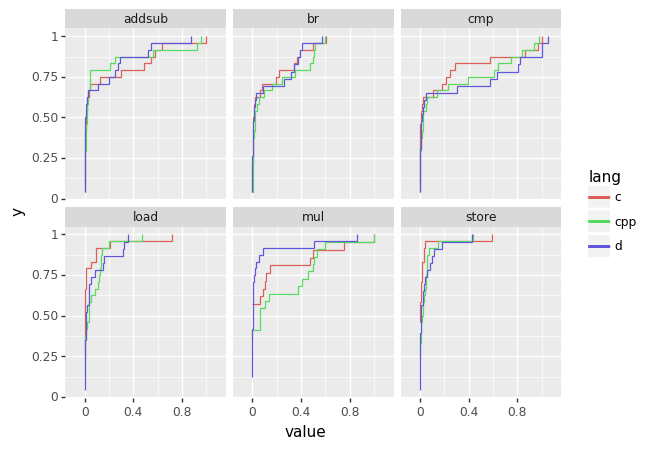

<ggplot: (-9223363260173699633)>

In [39]:
(ggplot(df) 
 + stat_ecdf(aes(x='value', colour='lang'))
 + facet_wrap('tipo') + xlim(-0.1, 1.1)
)